### Sports

In [1]:
import ast
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import torch
import warnings
warnings.filterwarnings('ignore')
from collections import defaultdict, Counter
from matplotlib.cm import get_cmap
from matplotlib.colors import to_hex
from tqdm import tqdm

In [2]:
dataset_name = "Sports"
dataset_dir = "/data/common/RecommendationDatasets/{dataset_name}_Amazon14/topics/".format(dataset_name=dataset_name)

topics = [
    "comfort", 
    "durability", 
    "fit", 
    "material", 
    "performance", 
    "portability", 
    "price",
    "safety", 
    "service", 
    "usability"
]

sentiments = [
    "positive",
    "negative",
    "neutral"
]

topics.sort()
print(topics)
with open(os.path.join(dataset_dir, "topics.json"), "w") as f:
    json.dump(topics, f)

['comfort', 'durability', 'fit', 'material', 'performance', 'portability', 'price', 'safety', 'service', 'usability']


In [3]:
data_df = pd.read_csv(os.path.join(dataset_dir, "statement.csv"))
data_df.head()

,helpful,reviewTime,rating,timestamp,review,user_name,user_id,item_id,review_title,statements
0,"[0, 0]","01 26, 2014",5.0,1390694400,This came in on time and I am veru happy with ...,David Briner,AIXZKN4ACSKI,1881509818,Woks very good,"[{'statement': 'arrives on time', 'topic': 'se..."
1,"[1, 1]","02 2, 2012",5.0,1328140800,I had a factory Glock tool that I was using fo...,Jason A. Kramer,A1L5P841VIO02V,1881509818,Works as well as the factory tool,[{'statement': 'has been used for multiple Glo...
2,"[2, 2]","02 28, 2012",4.0,1330387200,If you don't have a 3/32 punch or would like t...,J. Fernald,AB2W04NI4OEAD,1881509818,"It's a punch, that's all.",[{'statement': 'is suitable for users without ...
3,"[0, 0]","02 5, 2012",4.0,1328400000,This works no better than any 3/32 punch you w...,"Jusitn A. Watts ""Maverick9614""",A148SVSWKTJKU6,1881509818,It's a punch with a Glock logo.,[{'statement': 'does not perform better than a...
4,"[0, 0]","04 23, 2013",4.0,1366675200,I purchased this thinking maybe I need a speci...,Material Man,AAAWJ6LW9WMOO,1881509818,"Ok,tool does what a regular punch does.",[{'statement': 'Glock magazines have base plat...


In [4]:
statement_triplets = data_df["statements"].tolist()
print(statement_triplets[0:5])

["[{'statement': 'arrives on time', 'topic': 'service', 'sentiment': 'positive'}, {'statement': 'makes taking out pins easy', 'topic': 'usability', 'sentiment': 'positive'}]", "[{'statement': 'has been used for multiple Glock models', 'topic': 'fit', 'sentiment': 'neutral'}, {'statement': 'is reliable', 'topic': 'material', 'sentiment': 'positive'}, {'statement': 'is comparable to a factory tool', 'topic': 'performance', 'sentiment': 'positive'}]", "[{'statement': 'is suitable for users without a 3/32 punch', 'topic': 'usability', 'sentiment': 'neutral'}, {'statement': 'has a handy butt end for pushing pins', 'topic': 'usability', 'sentiment': 'positive'}, {'statement': 'is not necessary for users with a 3/32 punch', 'topic': 'usability', 'sentiment': 'neutral'}]", "[{'statement': 'does not perform better than a 3/32 punch from a hardware store', 'topic': 'performance', 'sentiment': 'negative'}, {'statement': 'a regular punch is preferred due to more holding surface', 'topic': 'fit', '

In [5]:
i = 0
for triplet_list in statement_triplets:
    triplet_list = ast.literal_eval(triplet_list)
    for triplet in triplet_list:
        statement = triplet.get("statement").lower().strip()
        topic = triplet.get("topic").lower().strip()
        sentiment = triplet.get("sentiment").lower().strip()

        print(statement.center(60), topic.center(20), sentiment.center(10), sep="|\t\t\t")
        i += 1

    if i > 40:
        break

                      arrives on time                       |			      service       |			 positive 
                 makes taking out pins easy                 |			     usability      |			 positive 
          has been used for multiple glock models           |			        fit         |			 neutral  
                        is reliable                         |			      material      |			 positive 
              is comparable to a factory tool               |			    performance     |			 positive 
         is suitable for users without a 3/32 punch         |			     usability      |			 neutral  
           has a handy butt end for pushing pins            |			     usability      |			 positive 
        is not necessary for users with a 3/32 punch        |			     usability      |			 neutral  
does not perform better than a 3/32 punch from a hardware store|			    performance     |			 negative 
  a regular punch is preferred due to more holding surface  |			        fit         |			 positive 
glock m

In [6]:
def process_triplets(statement_triplets, topics, sentiments):
    correct_triplets = {}
    wrong_topics = {}
    wrong_sentiments = {}
    wrong_topics_and_sentiments = {}
    
    for triplet_list in statement_triplets:
        if not triplet_list: continue
        if type(triplet_list) != list:
            try:
                triplet_list = ast.literal_eval(triplet_list)
            except:
                continue
    
        for triplet in triplet_list:
            if not triplet: continue

            accepted_topic = True
            accepted_sentiment = True
                
            topic = triplet.get("topic")
            if topic: topic = topic.lower().replace("-", " ").replace("_", " ").strip()
            else: continue
            if topic not in topics: accepted_topic = False

            sentiment = triplet.get("sentiment")
            if sentiment: sentiment = sentiment.lower().strip()
            else: continue
            if sentiment not in sentiments: accepted_sentiment = False
        
            statement = triplet.get("statement")
            if statement: statement = statement.lower().replace("-", " ").replace("_", " ").strip()
            else: continue
            
            if not (accepted_topic or accepted_sentiment):
                if topic not in wrong_topics_and_sentiments:
                    wrong_topics_and_sentiments[topic] = {}
                if sentiment not in wrong_topics_and_sentiments[topic]:
                    wrong_topics_and_sentiments[topic][sentiment] = {}
                if statement not in wrong_topics_and_sentiments[topic][sentiment]:
                    wrong_topics_and_sentiments[topic][sentiment][statement] = 0
                wrong_topics_and_sentiments[topic][sentiment][statement] += 1

            elif accepted_sentiment and not accepted_topic:
                if topic not in wrong_topics:
                    wrong_topics[topic] = {}
                if sentiment not in wrong_topics[topic]:
                    wrong_topics[topic][sentiment] = {}
                if statement not in wrong_topics[topic][sentiment]:
                    wrong_topics[topic][sentiment][statement] = 0
                wrong_topics[topic][sentiment][statement] += 1

            elif accepted_topic and not accepted_sentiment:
                if topic not in wrong_sentiments:
                    wrong_sentiments[topic] = {}
                if sentiment not in wrong_sentiments[topic]:
                    wrong_sentiments[topic][sentiment] = {}
                if statement not in wrong_sentiments[topic][sentiment]:
                    wrong_sentiments[topic][sentiment][statement] = 0
                wrong_sentiments[topic][sentiment][statement] += 1      

            else:
                if topic not in correct_triplets:
                    correct_triplets[topic] = {}
                if sentiment not in correct_triplets[topic]:
                    correct_triplets[topic][sentiment] = {}
                if statement not in correct_triplets[topic][sentiment]:
                    correct_triplets[topic][sentiment][statement] = 0
                correct_triplets[topic][sentiment][statement] += 1    
                
    return correct_triplets, wrong_topics, wrong_sentiments, wrong_topics_and_sentiments

In [7]:
correct_triplets, wrong_topics, wrong_sentiments, wrong_topics_and_sentiments = process_triplets(
    statement_triplets, topics, sentiments
)

In [8]:
len(correct_triplets), len(wrong_topics), len(wrong_sentiments), len(wrong_topics_and_sentiments)

(10, 154, 3, 1)

In [9]:
def build_topic_stats_df(topics):
    all_topics = sorted(topics.keys())
    all_sentiments = sorted({s for t in topics.values() for s in t.keys()})
    rows = []
    for topic in all_topics:
        row = {}
        uniq_total = 0
        freq_total = 0
        for s in all_sentiments:
            counts = topics[topic].get(s, {})
            u = len(counts)
            f = int(sum(counts.values())) if counts else 0
            row[(s, "unique")] = u
            row[(s, "total")] = f
            uniq_total += u
            freq_total += f
        row[("TOTAL", "unique")] = uniq_total
        row[("TOTAL", "total")] = freq_total
        rows.append(row)
    cols = []
    for s in all_sentiments:
        cols.append((s, "unique"))
        cols.append((s, "total"))
    cols.extend([("TOTAL", "unique"), ("TOTAL", "total")])
    df = pd.DataFrame(rows, index=all_topics, columns=pd.MultiIndex.from_tuples(cols))
    df = df.fillna(0).astype(int)
    return df

In [10]:
correct_triplets_df_stats = build_topic_stats_df(correct_triplets)
print(correct_triplets_df_stats)

            negative        neutral        positive           TOTAL        
              unique  total  unique  total   unique   total  unique   total
comfort        10946  11909    3240   3368    42997   63998   57183   79275
durability     35097  38900    6784   7374    51776   90848   93657  137122
fit            34998  39175   29221  31329    78510   96676  142729  167180
material       36294  40195   48373  52901   100015  145941  184682  239037
performance    35691  38584   16953  18008   167464  226803  220108  283395
portability    11261  15214   11111  12554    49446   78928   71818  106696
price          12244  17521    7348   8352    32995   73919   52587   99792
safety         18151  18807    5438   5534    30503   33748   54092   58089
service         6873   7603    3499   3661    20263   33135   30635   44399
usability      37992  40775   37001  39300   113374  151255  188367  231330


In [11]:
correct_triplets_df_stats.sum(axis=0)

negative  unique     239547
          total      268683
neutral   unique     168968
          total      182381
positive  unique     687343
          total      995251
TOTAL     unique    1095858
          total     1446315
dtype: int64

In [12]:
print(wrong_sentiments, wrong_topics_and_sentiments)

{'performance': {'mixed': {'is partly effective in scaring dogs': 1, 'horn works, but has mixed results in scaring dogs': 1}, 'hopeful': {'works well as range belt': 1}, 'false': {'works with all shell holders': 1}}, 'safety': {'cautionary': {'can withstand.45 caliber, but with caution': 1}}, 'price': {'conditional positive': {'would buy again if had mechanical lock': 1}}} {'none': {'none': {'i love it': 1, 'recommend it': 1}}}


In [13]:
wrong_topics_df_stats = build_topic_stats_df(wrong_topics)
print(wrong_topics_df_stats)

                negative       neutral       positive        TOTAL      
                  unique total  unique total   unique total unique total
absorbency             1     1       1     1        0     0      2     2
accessories            1     1       5     5       18    18     24    24
accessory              0     0       0     0        1     1      1     1
accuracy               2     2       3     3        1     1      6     6
adhesion               0     0       0     0        1     1      1     1
...                  ...   ...     ...   ...      ...   ...    ...   ...
waterproofing         30    30       5     5       94    97    129   132
waterproofness         2     2       1     1       12    12     15    15
weather                1     1       5     5        0     0      6     6
weight                14    14      23    24       15    17     52    55
wind resistance        0     0       0     0        2     2      2     2

[154 rows x 8 columns]


In [14]:
wrong_topics_df_stats.sum(axis=0)

negative  unique     717
          total      733
neutral   unique     857
          total      872
positive  unique    3140
          total     3935
TOTAL     unique    4714
          total     5540
dtype: int64

In [15]:
(wrong_topics_df_stats.sum(axis=0) / (wrong_topics_df_stats.sum(axis=0) + correct_triplets_df_stats.sum(axis=0))) * 100

negative  unique    0.298422
          total     0.272070
neutral   unique    0.504637
          total     0.475845
positive  unique    0.454754
          total     0.393821
TOTAL     unique    0.428323
          total     0.381581
dtype: float64

In [16]:
wrong_topics_stats = wrong_topics_df_stats["TOTAL"]["unique"].to_dict()
print(wrong_topics_stats)

{'absorbency': 2, 'accessories': 24, 'accessory': 1, 'accuracy': 6, 'adhesion': 1, 'adhesive': 1, 'adjustability': 2, 'aesthetic': 3, 'aesthetics': 433, 'appearance': 926, 'audio': 4, 'authenticity': 2, 'availability': 134, 'balance': 20, 'battery life': 3, 'bling': 1, 'brand': 121, 'brand comparison': 1, 'brand loyalty': 4, 'brand preference': 1, 'brand recognition': 1, 'brand reputation': 12, 'branding': 1, 'breathability': 1, 'capacity': 97, 'care': 2, 'cleanability': 1, 'cleaning': 1, 'collection': 1, 'color': 47, 'comparison': 7, 'compatibility': 336, 'concealment': 3, 'concept': 1, 'condition': 2, 'confidence': 1, 'cons': 1, 'content': 4, 'cool factor': 3, 'cosmetics': 2, 'delivery': 1, 'description': 3, 'design': 169, 'desirability': 1, 'desire': 3, 'difficulty': 3, 'endurance': 1, 'enjoyment': 1, 'environment': 2, 'experience': 3, 'extras': 1, 'fashion': 1, 'features': 2, 'feel': 1, 'fitness': 8, 'flavor': 2, 'food': 4, 'food quality': 2, 'form': 2, 'fun': 1, 'function': 4, 'fu

In [17]:
# try to assign correct topic if possible
for topic in wrong_topics:
    print(topic)
    for sent in wrong_topics[topic]:
        statements = wrong_topics[topic][sent]
        statements = list(dict(sorted(statements.items(), key=lambda x: x[1])))
        if len(statements) > 4:
            statements = statements[:4]
        print("\t", sent, ":", "\n\t\t".join(statements))

recommendation
	 negative : would recommend set with attached handles
		co2 is not recommended for electronic markers
		not recommended for electronic markers
		would recommend using alternative
	 positive : recommended for cleaning shotgun
		are recommended for black socks
		hpa is best for electronic markers
		recommended for classic or mechanical markers
	 neutral : co2 is preferred for mechanical markers
		recommend using a heavier machete, ax, or hatchet for tree chopping
		should be considered for occasional use
		finds flat nylon pull tape as alternative
usage
	 neutral : item has not been used yet
		used for wilderness camping
		is used only for outside cleaning
		has been used in the field for about 1 year
	 positive : is often used around the home
		is used frequently
		will use it when the season opens again
		is used more frequently than iwb holster
	 negative : won't get much use
security
	 negative : easy to crack the combo in less than 40 minutes
		is not theft proof
		n

**Prompt** : ```The extraction of triplets (atomic statement, topic, sentiment) from reviews produced topics that are not in the accepted topics list (represented by their short name). I will give you the list of incorrect topics, with a few example statements per sentiment. Analyze the statements and estimate the closest accepted topic it can be assigned to. If no statement is provided, do not assign anything; and if an assignment is impossible, do not assign one either. Here are the examples [EXAMPLES]. Here is the list of accepted topics for the Amazon Sports dataset:
ACCEPTED TOPICS (short name (long name): description) [TOPICS]
You must output a JSON object; keys are the incorrect topics and their values are the short name of the accepted topic they’re assigned to. Use None for incorrect topics that are not assigned.```

In [18]:
gpt_assignation = {
    "recommendation": None,
    "usage": None,
    "security": "safety",
    "overall": None,
    "appearance": None,
    "aesthetics": None,
    "maintenance": "usability",
    "availability": None,
    "size": "fit",
    "popularity": None,
    "history": None,
    "waterproofing": "material",
    "purchase": None,
    "packaging": "service",
    "market": None,
    "design": "usability",
    "compatibility": "usability",
    "noise": "performance",
    "value": "price",
    "water resistance": "material",
    "storage": "portability",
    "brand": None,
    "visibility": "safety",
    "weight": "portability",
    "quality": "material",
    "comparison": None,
    "concealment": "portability",
    "style": None,
    "insulation": "comfort",
    "user": None,
    "reusability": "durability",
    "taste": None,
    "nutrition": "performance",
    "color": None,
    "adhesive": "material",
    "adhesion": "material",
    "reliability": "durability",
    "seller": "service",
    "flavor": None,
    "none": None,
    "accessories": "usability",
    "cons": None,
    "feel": "comfort",
    "look": None,
    "general": None,
    "stability": "safety",
    "grip": "performance",
    "waterproof": "material",
    "sustainability": None,
    "repair": "usability",
    "capacity": "portability",
    "waterproofness": "material",
    "content": None,
    "quantity": "price",
    "subjective opinion": None,
    "balance": "performance",
    "brand reputation": None,
    "purpose": "usability",
    "reputation": None,
    "loyalty": None,
    "weather": None,
    "desire": None,
    "brand recognition": None,
    "condition": "material",
    "description": "service",
    "unspecified": None,
    "enjoyment": None,
    "experience": None,
    "instructions": "usability",
    "stain resistance": "material",
    "origin": None,
    "sound": "performance",
    "functionality": "performance",
    "fitness": None,
    "extras": "usability",
    "accuracy": "performance",
    "function": "performance",
    "marketing": None,
    "manufacturing": "material",
    "care": "usability",
    "uniqueness": None,
    "target audience": None,
    "cool factor": None,
    "unknown": None,
    "quality control": "material",
    "branding": None,
    "general impression": None,
    "mechanism": "usability",
    "organization": "portability",
    "form": None,
    "cleanability": "usability",
    "preference": None,
    "endurance": "comfort",
    "fun": None,
    "product": None,
    "name": None,
    "cleaning": "usability",
    "looks": None,
    "authenticity": None,
    "information": "service",
    "difficulty": "usability",
    "kit": "usability",
    "desirability": None,
    "volume": "portability",
    "social impact": None,
    "noise reduction": "performance",
    "sensitivity": "performance",
    "adjustability": "usability",
    "water repellency": "material",
    "realism": None,
    "accessory": "usability",
    "image": None,
    "brand preference": None,
    "wind resistance": "performance",
    "warmth": "comfort",
    "novelty": None,
    "leakage": "material",
    "use": "usability",
    "overall quality": "material",
    "personal": None,
    "temperature": None,
    "brand loyalty": None,
    "warranty": "service",
    "light coverage": "performance",
    "aesthetic": None,
    "use case": "usability",
    "features": "usability",
    "bling": None,
    "audio": "performance",
    "presentation": None,
    "battery life": "performance",
    "ventilation": "comfort",
    "brand comparison": None,
    "environment": None,
    "pop culture": None,
    "collection": None,
    "delivery": "service",
    "fashion": None,
    "cosmetics": None,
    "food quality": None,
    "perception": None,
    "absorbency": "material",
    "food": None,
    "confidence": None,
    "oxy sorbs": None,
    "breathability": "comfort",
    "personal preference": None,
    "net": "material",
    "length": "fit",
    "variety": None,
    "research": None,
    "psychological impact": None,
    "thickness": "material",
    "concept": None
}

In [19]:
claude_assignation = {
  "recommendation": "performance",
  "usage": "performance",
  "security": "safety",
  "overall": "price",
  "appearance": "material",
  "aesthetics": "material",
  "maintenance": "usability",
  "availability": "service",
  "size": "fit",
  "popularity": "price",
  "history": None,
  "waterproofing": "material",
  "purchase": None,
  "packaging": "service",
  "market": None,
  "design": "material",
  "compatibility": "performance",
  "noise": "performance",
  "value": "price",
  "water resistance": "material",
  "storage": "portability",
  "brand": "price",
  "visibility": "performance",
  "weight": "portability",
  "quality": "material",
  "comparison": "price",
  "concealment": "fit",
  "style": "material",
  "insulation": "material",
  "user": None,
  "reusability": "durability",
  "taste": None,
  "nutrition": None,
  "color": "material",
  "adhesive": "material",
  "adhesion": "material",
  "reliability": "durability",
  "seller": "service",
  "flavor": None,
  "none": None,
  "accessories": "material",
  "cons": None,
  "feel": "comfort",
  "look": "material",
  "general": None,
  "stability": "safety",
  "grip": "performance",
  "waterproof": "material",
  "sustainability": None,
  "repair": "usability",
  "capacity": "fit",
  "waterproofness": "material",
  "content": None,
  "quantity": None,
  "subjective opinion": None,
  "balance": "performance",
  "brand reputation": "price",
  "purpose": None,
  "reputation": "price",
  "loyalty": None,
  "weather": None,
  "desire": None,
  "brand recognition": "price",
  "condition": "material",
  "description": "service",
  "unspecified": None,
  "enjoyment": None,
  "experience": None,
  "instructions": "usability",
  "stain resistance": "material",
  "origin": None,
  "sound": "performance",
  "functionality": "performance",
  "fitness": None,
  "extras": "material",
  "accuracy": "performance",
  "function": "performance",
  "marketing": None,
  "manufacturing": None,
  "care": "usability",
  "uniqueness": None,
  "target audience": None,
  "cool factor": None,
  "unknown": None,
  "quality control": "material",
  "branding": None,
  "general impression": None,
  "mechanism": "material",
  "organization": "portability",
  "form": "material",
  "cleanability": "usability",
  "preference": None,
  "endurance": "durability",
  "fun": None,
  "product": None,
  "name": None,
  "cleaning": "usability",
  "looks": "material",
  "authenticity": "material",
  "information": "service",
  "difficulty": "usability",
  "kit": None,
  "desirability": None,
  "volume": "fit",
  "social impact": None,
  "noise reduction": "performance",
  "sensitivity": "performance",
  "adjustability": "fit",
  "water repellency": "material",
  "realism": "material",
  "accessory": "material",
  "image": None,
  "brand preference": "price",
  "wind resistance": "material",
  "warmth": "comfort",
  "novelty": None,
  "leakage": "material",
  "use": "performance",
  "overall quality": "material",
  "personal": None,
  "temperature": None,
  "brand loyalty": "price",
  "warranty": "service",
  "light coverage": "performance",
  "aesthetic": "material",
  "use case": "performance",
  "features": "material",
  "bling": "material",
  "audio": "performance",
  "presentation": "performance",
  "battery life": "performance",
  "ventilation": "material",
  "brand comparison": "price",
  "environment": None,
  "pop culture": None,
  "collection": None,
  "delivery": "service",
  "fashion": None,
  "cosmetics": "material",
  "food quality": None,
  "perception": None,
  "absorbency": "material",
  "food": None,
  "confidence": None,
  "oxy sorbs": None,
  "breathability": "comfort",
  "personal preference": None,
  "net": "material",
  "length": "fit",
  "variety": None,
  "research": None,
  "psychological impact": None,
  "thickness": "fit",
  "concept": None
}

In [20]:
gemini_assignation = {
  "recommendation": None,
  "usage": "usability",
  "security": "safety",
  "overall": "performance",
  "appearance": None,
  "aesthetics": None,
  "maintenance": "usability",
  "availability": None,
  "size": "fit",
  "popularity": None,
  "history": None,
  "waterproofing": "performance",
  "purchase": None,
  "packaging": None,
  "market": None,
  "design": None,
  "compatibility": "usability",
  "noise": None,
  "value": "price",
  "water resistance": "performance",
  "storage": "portability",
  "brand": None,
  "visibility": "safety",
  "weight": "portability",
  "quality": "durability",
  "comparison": "performance",
  "concealment": "usability",
  "style": None,
  "insulation": "performance",
  "user": None,
  "reusability": "durability",
  "taste": None,
  "nutrition": None,
  "color": None,
  "adhesive": "performance",
  "adhesion": "performance",
  "reliability": "durability",
  "seller": "service",
  "flavor": None,
  "none": None,
  "accessories": None,
  "cons": None,
  "feel": "comfort",
  "look": None,
  "general": "performance",
  "stability": "safety",
  "grip": "performance",
  "waterproof": "performance",
  "sustainability": "durability",
  "repair": "usability",
  "capacity": "usability",
  "waterproofness": "performance",
  "content": None,
  "quantity": None,
  "subjective opinion": None,
  "balance": "performance",
  "brand reputation": None,
  "purpose": "usability",
  "reputation": None,
  "loyalty": None,
  "weather": None,
  "desire": None,
  "brand recognition": None,
  "condition": None,
  "description": None,
  "unspecified": None,
  "enjoyment": None,
  "experience": None,
  "instructions": "usability",
  "stain resistance": "durability",
  "origin": None,
  "sound": None,
  "functionality": "performance",
  "fitness": None,
  "extras": None,
  "accuracy": "performance",
  "function": "usability",
  "marketing": None,
  "manufacturing": None,
  "care": "usability",
  "uniqueness": None,
  "target audience": None,
  "cool factor": None,
  "unknown": None,
  "quality control": "durability",
  "branding": None,
  "general impression": "performance",
  "mechanism": "performance",
  "organization": "usability",
  "form": None,
  "cleanability": "usability",
  "preference": None,
  "endurance": "comfort",
  "fun": None,
  "product": None,
  "name": None,
  "cleaning": "usability",
  "looks": None,
  "authenticity": None,
  "information": None,
  "difficulty": None,
  "kit": None,
  "desirability": None,
  "volume": "portability",
  "social impact": None,
  "noise reduction": "performance",
  "sensitivity": "performance",
  "adjustability": "fit",
  "water repellency": "performance",
  "realism": None,
  "accessory": None,
  "image": None,
  "brand preference": None,
  "wind resistance": "performance",
  "warmth": "performance",
  "novelty": None,
  "leakage": "performance",
  "use": "usability",
  "overall quality": "durability",
  "personal": None,
  "temperature": None,
  "brand loyalty": None,
  "warranty": "service",
  "light coverage": "performance",
  "aesthetic": None,
  "use case": "usability",
  "features": "usability",
  "bling": None,
  "audio": "performance",
  "presentation": None,
  "battery life": "performance",
  "ventilation": "performance",
  "brand comparison": None,
  "environment": None,
  "pop culture": None,
  "collection": None,
  "delivery": "service",
  "fashion": None,
  "cosmetics": None,
  "food quality": None,
  "perception": None,
  "absorbency": "performance",
  "food": None,
  "confidence": None,
  "oxy sorbs": None,
  "breathability": "performance",
  "personal preference": None,
  "net": "durability",
  "length": "fit",
  "variety": None,
  "research": None,
  "psychological impact": None,
  "thickness": "fit",
  "concept": None
}

In [21]:
remain_wrong_topics = [t for t, n_st in wrong_topics_stats.items() if n_st >= 10]
print(remain_wrong_topics)
print(len(remain_wrong_topics))

['accessories', 'aesthetics', 'appearance', 'availability', 'balance', 'brand', 'brand reputation', 'capacity', 'color', 'compatibility', 'design', 'general', 'history', 'maintenance', 'noise', 'none', 'overall', 'packaging', 'popularity', 'purchase', 'purpose', 'quality', 'recommendation', 'reliability', 'security', 'size', 'stability', 'style', 'taste', 'unknown', 'usage', 'value', 'visibility', 'water resistance', 'waterproofing', 'waterproofness', 'weight']
37


In [22]:
final_assignation = {}
for topic in wrong_topics:
    assignations = [
        gpt_assignation.get(topic, None),
        claude_assignation.get(topic, None),
        gemini_assignation.get(topic, None)
    ]
    value_set = set(assignations)
    for value in value_set:
        if value is None: continue
        if assignations.count(value) == 3:
            final_assignation[topic] = value

In [23]:
final_assignation

{'security': 'safety',
 'maintenance': 'usability',
 'size': 'fit',
 'value': 'price',
 'storage': 'portability',
 'weight': 'portability',
 'reusability': 'durability',
 'reliability': 'durability',
 'seller': 'service',
 'feel': 'comfort',
 'stability': 'safety',
 'grip': 'performance',
 'repair': 'usability',
 'balance': 'performance',
 'instructions': 'usability',
 'functionality': 'performance',
 'accuracy': 'performance',
 'care': 'usability',
 'cleanability': 'usability',
 'cleaning': 'usability',
 'noise reduction': 'performance',
 'sensitivity': 'performance',
 'warranty': 'service',
 'light coverage': 'performance',
 'audio': 'performance',
 'battery life': 'performance',
 'delivery': 'service',
 'length': 'fit'}

In [24]:
extend_correct_triplets = correct_triplets.copy()
for wrong, correct in final_assignation.items():
    for sent in wrong_topics[wrong]:
        if sent not in extend_correct_triplets[correct]:
            extend_correct_triplets[correct][sent] = {}
        for statement in wrong_topics[wrong][sent]:
            if statement not in extend_correct_triplets[correct][sent]:
                extend_correct_triplets[correct][sent][statement] = 0
            extend_correct_triplets[correct][sent][statement] += wrong_topics[wrong][sent][statement]

In [25]:
extend_correct_triplets_df_stats = build_topic_stats_df(extend_correct_triplets)
print(extend_correct_triplets_df_stats)

            negative        neutral        positive           TOTAL        
              unique  total  unique  total   unique   total  unique   total
comfort        10946  11909    3240   3368    42997   63999   57183   79276
durability     35100  38903    6785   7375    51783   90857   93668  137135
fit            35012  39201   29264  31386    78536   96718  142812  167305
material       36294  40195   48373  52901   100015  145941  184682  239037
performance    35703  38596   16965  18021   167486  226827  220154  283444
portability    11273  15228   11129  12578    49461   78948   71863  106754
price          12268  17546    7363   8367    33212   74203   52843  100116
safety         18180  18841    5446   5542    30603   33861   54229   58244
service         6874   7604    3501   3663    20263   33135   30638   44402
usability      38005  40790   37098  39416   113434  151321  188537  231527


In [26]:
extend_correct_triplets_df_stats.sum(axis=0)

negative  unique     239655
          total      268813
neutral   unique     169164
          total      182617
positive  unique     687790
          total      995810
TOTAL     unique    1096609
          total     1447240
dtype: int64

In [27]:
def process_dataset(data_df, topics, corrected_topics):
    corrected_topics_list = list(corrected_topics)

    all_triplets = {}
    cleaned_statements = []
    statement_idss = []
    topic_idss = []
    sentiment_idss = []
    sentiment_map = {"positive": +1, "neutral": 0, "negative": -1}
    
    for index, triplet_list in enumerate(data_df["statements"].tolist(), start=1):
        try:
            triplet_list = ast.literal_eval(triplet_list)
        except:
            cleaned_statements.append(None)
            statement_idss.append(None)
            topic_idss.append(None)
            sentiment_idss.append(None)
            continue

        new_triplet_list = []
        statement_ids = []
        topic_ids = []
        sentiment_ids = []
        
        for triplet in triplet_list:
            if not triplet: continue

            topic = triplet.get("topic")
            if topic: topic = topic.lower().replace("-", " ").replace("_", " ").strip()
            else: continue
            if topic not in (topics + corrected_topics_list): continue
            if topic in corrected_topics_list: topic = corrected_topics[topic]

            sentiment = triplet.get("sentiment")
            if sentiment: sentiment = sentiment.lower().strip()
            if sentiment not in sentiment_map: continue
                
            statement = triplet.get("statement")
            if statement: statement = statement.lower().replace("-", " ").replace("_", " ").strip()
            else: continue

            triplet_tuple = (statement, topic, sentiment)
            if triplet_tuple not in all_triplets:
                new_id = len(all_triplets)
                all_triplets[triplet_tuple] = {}
                all_triplets[triplet_tuple]["id"] = new_id
                all_triplets[triplet_tuple]["freq"] = 0
                
            all_triplets[triplet_tuple]["freq"] += 1

            topic_id = topics.index(topic)
            sentiment_id = sentiment_map[sentiment]
            statement_id = all_triplets[triplet_tuple]["id"]

            new_triplet = {"statement": statement, "topic": topic, "sentiment": sentiment}
            new_triplet_list.append(new_triplet)
            statement_ids.append(statement_id)
            topic_ids.append(topic_id)
            sentiment_ids.append(sentiment_id)

        if len(new_triplet_list) == 0:
            new_triplet_list = None
            statement_ids = None
            topic_ids = None
            sentiment_ids = None
            
        cleaned_statements.append(new_triplet_list)
        statement_idss.append(statement_ids)
        topic_idss.append(topic_ids)
        sentiment_idss.append(sentiment_ids)

        if index % 10_000 == 0:
            print("10000 samples processed...")

    print("Done!")
    n_none = cleaned_statements.count(None)
    print("Number of fails:", n_none)
    print("% of fails:", n_none/len(data_df))

    new_data_df = pd.DataFrame(data_df)
    new_data_df["statements"] = cleaned_statements
    new_data_df["statement_ids"] = statement_idss
    new_data_df["topic_ids"] = topic_idss
    new_data_df["sentiments"] = sentiment_idss
        
    columns = ["user_id", "item_id", "timestamp", "rating", "statements", "statement_ids", "topic_ids", "sentiments"]
    #new_data_df = new_data_df[columns]
    new_data_df = new_data_df.dropna(subset=columns)

    return new_data_df, all_triplets

In [28]:
new_data_df, all_triplets = process_dataset(data_df, topics, final_assignation)
print(new_data_df.head())

10000 samples processed...


10000 samples processed...


10000 samples processed...


10000 samples processed...


10000 samples processed...


10000 samples processed...


10000 samples processed...


10000 samples processed...


10000 samples processed...


10000 samples processed...


10000 samples processed...


10000 samples processed...


10000 samples processed...


10000 samples processed...


10000 samples processed...


10000 samples processed...


10000 samples processed...


10000 samples processed...


10000 samples processed...


10000 samples processed...


10000 samples processed...


10000 samples processed...


10000 samples processed...


10000 samples processed...


10000 samples processed...


10000 samples processed...


10000 samples processed...


10000 samples processed...


Done!
Number of fails: 3093
% of fails: 0.010437441156521123


  helpful   reviewTime  rating   timestamp  \
0  [0, 0]  01 26, 2014     5.0  1390694400   
1  [1, 1]   02 2, 2012     5.0  1328140800   
2  [2, 2]  02 28, 2012     4.0  1330387200   
3  [0, 0]   02 5, 2012     4.0  1328400000   
4  [0, 0]  04 23, 2013     4.0  1366675200   

                                              review  \
0  This came in on time and I am veru happy with ...   
1  I had a factory Glock tool that I was using fo...   
2  If you don't have a 3/32 punch or would like t...   
3  This works no better than any 3/32 punch you w...   
4  I purchased this thinking maybe I need a speci...   

                        user_name         user_id     item_id  \
0                    David Briner    AIXZKN4ACSKI  1881509818   
1                 Jason A. Kramer  A1L5P841VIO02V  1881509818   
2                      J. Fernald   AB2W04NI4OEAD  1881509818   
3  Jusitn A. Watts "Maverick9614"  A148SVSWKTJKU6  1881509818   
4                    Material Man   AAAWJ6LW9WMOO  1881509818

In [29]:
statement_triplets = new_data_df["statements"].to_list()
len(statement_triplets)

293244

In [30]:
correct_triplets, wrong_topics, wrong_sentiments, wrong_topics_and_sentiments = process_triplets(
    statement_triplets, topics, sentiments
)

In [31]:
len(correct_triplets), len(wrong_topics), len(wrong_sentiments), len(wrong_topics_and_sentiments)

(10, 0, 0, 0)

In [32]:
final_correct_triplets_df_stats = build_topic_stats_df(correct_triplets)
print(final_correct_triplets_df_stats)

            negative        neutral        positive           TOTAL        
              unique  total  unique  total   unique   total  unique   total
comfort        10946  11909    3240   3368    42997   63999   57183   79276
durability     35100  38903    6785   7375    51783   90857   93668  137135
fit            35012  39201   29264  31386    78536   96718  142812  167305
material       36294  40195   48373  52901   100015  145941  184682  239037
performance    35703  38596   16965  18021   167486  226827  220154  283444
portability    11273  15228   11129  12578    49461   78948   71863  106754
price          12268  17546    7363   8367    33212   74203   52843  100116
safety         18180  18841    5446   5542    30603   33861   54229   58244
service         6874   7604    3501   3663    20263   33135   30638   44402
usability      38005  40790   37098  39416   113434  151321  188537  231527


In [33]:
def plot_topic_sentiment_bars(
    df: pd.DataFrame,
    save_pdf_path: str | None = None,
    figsize=(11, 6.5)
):
    mpl.rcParams['axes.prop_cycle'] = plt.cycler(color=[
        "#8da0cb", "#fc8d62", "#66c2a5", "#e78ac3", "#a6d854"
    ])
    mpl.rcParams['grid.linestyle'] = ":"
    mpl.rcParams['grid.linewidth'] = 0.6
    mpl.rcParams['grid.alpha'] = 0.7
    mpl.rcParams['font.family'] = 'serif'
    mpl.rcParams['font.size'] = 12
    mpl.rcParams['legend.fontsize'] = 10
    mpl.rcParams['legend.frameon'] = False
    mpl.rcParams['axes.spines.top'] = False
    mpl.rcParams['axes.spines.right'] = False

    def get_col(df, sent, kind):
        if isinstance(df.columns, pd.MultiIndex):
            if (sent, kind) in df.columns:
                return df[(sent, kind)]
            for a, b in df.columns:
                if str(a).lower() == sent and str(b).lower() == kind:
                    return df[(a, b)]
        else:
            candidates = [
                f"{sent} {kind}",
                f"{sent}_{kind}",
                f"{sent}.{kind}",
                f"{sent.capitalize()} {kind}",
                f"{sent.capitalize()}_{kind}",
            ]
            for c in candidates:
                if c in df.columns:
                    return df[c]
            for c in df.columns:
                if sent in str(c).lower() and kind in str(c).lower():
                    return df[c]
        return pd.Series(0, index=df.index, dtype=float)

    def drop_total(df):
        if isinstance(df.columns, pd.MultiIndex):
            keep = [c for c in df.columns if str(c[0]).lower() != "total"]
            return df.loc[:, keep]
        else:
            keep = [c for c in df.columns if "total" != str(c).strip().lower()]
            return df[[c for c in df.columns if not str(c).lower().startswith("total ")]]

    df = drop_total(df).copy()
    df = df.sort_index(ascending=False)

    neg_u = get_col(df, "negative", "unique").astype(float)
    neg_t = get_col(df, "negative", "total").astype(float)
    neu_u = get_col(df, "neutral",  "unique").astype(float)
    neu_t = get_col(df, "neutral",  "total").astype(float)
    pos_u = get_col(df, "positive", "unique").astype(float)
    pos_t = get_col(df, "positive", "total").astype(float)

    fig, ax = plt.subplots(figsize=figsize)

    topics = df.index.to_list()
    y = np.arange(len(topics))

    group_height = 0.78
    n_series = 6
    bar_h = group_height / n_series

    NEG = "#d73027"
    NEU = "#377eb8"
    POS = "#1a9850"

    colors = {
        "neg_u": (NEG, 0.55),
        "neg_t": (NEG, 1.00),
        "neu_u": (NEU, 0.55),
        "neu_t": (NEU, 1.00),
        "pos_u": (POS, 0.55),
        "pos_t": (POS, 1.00),
    }

    series = [
        ("neg_u", neg_u, "Negative · Unique"),
        ("neg_t", neg_t, "Negative · Total"),
        ("neu_u", neu_u, "Neutral · Unique"),
        ("neu_t", neu_t, "Neutral · Total"),
        ("pos_u", pos_u, "Positive · Unique"),
        ("pos_t", pos_t, "Positive · Total"),
    ]

    start = y - group_height / 2 + 0.05
    for i, (key, values, label) in enumerate(series):
        c, a = colors[key]
        ax.barh(start + i * bar_h,
                values.values,
                height=bar_h * 0.92,
                label=label,
                color=c,
                alpha=a,
                edgecolor="none")

    ax.set_yticks(y)
    ax.set_yticklabels(topics)
    ax.set_xlabel("Count of statements")
    #ax.set_title("Topic × Sentiment")

    ax.grid(axis="x", which="both")
    ax.set_axisbelow(True)

    handles, labels = ax.get_legend_handles_labels()
    handles = handles[0::2] + handles[1::2]
    labels = labels[0::2] + labels[1::2]
    seen = set()
    h2, l2 = [], []
    for h, l in zip(handles, labels):
        if l not in seen:
            seen.add(l)
            h2.append(h)
            l2.append(l)
    ax.legend(h2, l2, ncols=2, loc="lower right", bbox_to_anchor=(1.0, 0.0), frameon=True)

    plt.tight_layout()

    if save_pdf_path:
        plt.savefig(save_pdf_path, dpi=300, bbox_inches="tight")
    plt.show()


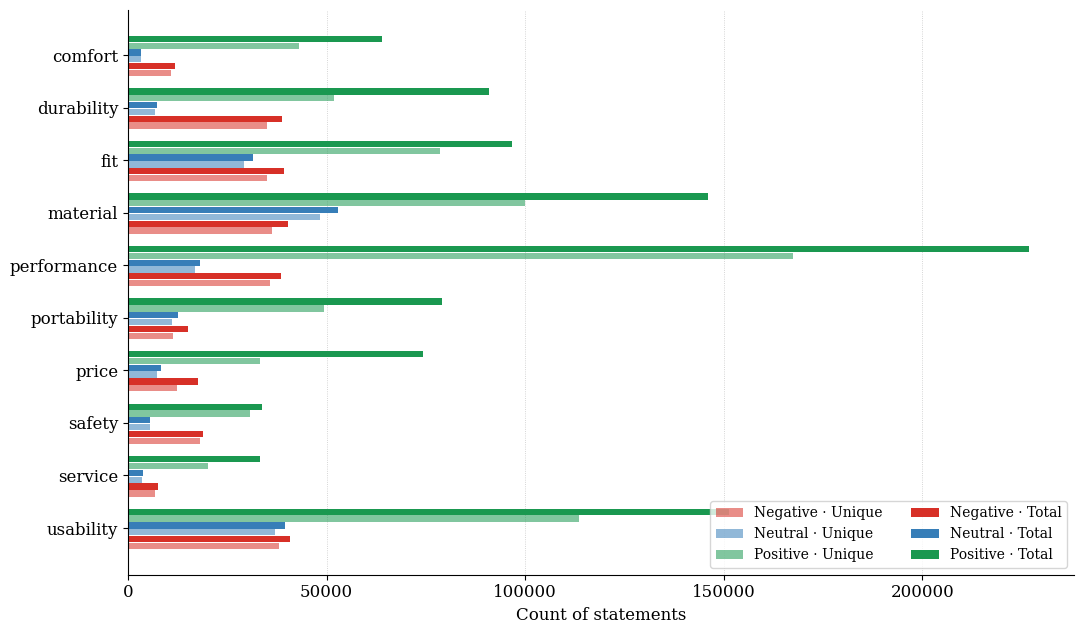

In [34]:
os.makedirs("plots", exist_ok=True)
plot_topic_sentiment_bars(
    final_correct_triplets_df_stats, 
    os.path.join("plots", dataset_name + "_topic_sentiment_statement_distribution.pdf")
)

In [35]:
new_data_df.to_csv(os.path.join(dataset_dir, "processed_dataset.csv"))

In [36]:
all_statements = []
all_topics = []
all_sentiments = []
all_freq = []

for i, ((statement, topic, sent), id_freq) in enumerate(all_triplets.items()):
    freq = id_freq["freq"]
    all_statements.append(statement)
    all_topics.append(topic)
    all_sentiments.append(sent)
    all_freq.append(freq)
    if i % 10_000 == 0:
        print((statement, topic, sent), freq)

statement_topic_sentiment_freq_df = pd.DataFrame({
    "statement": all_statements,
    "topic": all_topics,
    "sentiment": all_sentiments,
    "frequency": all_freq
})

print(len(statement_topic_sentiment_freq_df))

('arrives on time', 'service', 'positive') 646
('image is clear only in the center', 'performance', 'neutral') 1
('recommended to take to gunsmith for proper blueing', 'service', 'positive') 1
('does not handle training wheels on kids bikes well', 'performance', 'negative') 1
('has a standard hogue logo', 'material', 'neutral') 1
('bee wax is an alternative', 'material', 'neutral') 1
('feature flip tops for ease of use in bath or shower', 'usability', 'positive') 1
('returns the product', 'service', 'negative') 1
('has performed well', 'performance', 'positive') 12
('features front and back deep slash pockets', 'fit', 'positive') 1
('alloy stems are scarce for long quill stems', 'material', 'neutral') 1
('serves its purpose well as a defense gun', 'performance', 'positive') 1
('risk of losing knife when carried in sweats', 'portability', 'negative') 1
("bristles are finer than hoppe's bore brushes", 'performance', 'positive') 1
('net door provides sunlight and air', 'comfort', 'positiv

('fits comfortably in gloves', 'fit', 'positive') 1
('can hold large guns with lights', 'fit', 'positive') 1
('requires ear plugs for larger caliber rifles and pistols', 'safety', 'negative') 1
('plain, solid color bottles are beautiful', 'material', 'positive') 1
('is not distracting while riding', 'usability', 'positive') 1
('needs additional sharpening', 'performance', 'neutral') 1
('brass punch set is recommended', 'material', 'neutral') 1
('features twist lock for added security', 'safety', 'positive') 1
('arrives quickly, within two days', 'service', 'positive') 4
('can be worn belted in without issue', 'portability', 'positive') 1
('wipes clean with rag', 'usability', 'positive') 1
('is suitable for smaller hands', 'fit', 'neutral') 1
('lacks aesthetic appeal', 'material', 'negative') 2
('blade is not too heavy', 'portability', 'positive') 1
('adjust to fit the head', 'fit', 'positive') 1
('filtration system is recommended for backpacking', 'safety', 'positive') 1
('have no play

('lacks rim or seal on the bowl', 'durability', 'negative') 1
('requires caution when shooting at hard wood', 'safety', 'negative') 1
('is as tough as nails', 'durability', 'positive') 1
('require batteries', 'performance', 'neutral') 1
('user has above average fitness level', 'fit', 'positive') 1
('feels comfortable for hunting in brush', 'comfort', 'positive') 1
('has one light source', 'material', 'neutral') 1
("achieve partial penetration of 1/2 ply behind a 2'' foam target", 'performance', 'positive') 1
('retains classic military look', 'fit', 'positive') 1
('fits easily in utg pistol grip', 'fit', 'positive') 1
('has a closer gear ratio', 'performance', 'positive') 1
('works well on a fly rod', 'usability', 'positive') 1
('short extension fits well, but a tiny bit less so', 'fit', 'neutral') 1
('includes a military type rod', 'material', 'positive') 1
('reduce frustration when loading', 'usability', 'positive') 1
('glasses fit comfortably on the largest setting', 'comfort', 'posi

('allow use of iron sights for practice', 'usability', 'positive') 1
('provides quick hide for pack', 'portability', 'positive') 1
('gel formula works well', 'material', 'positive') 1
('company values customer feedback', 'service', 'neutral') 1
('see thru section provides visibility for iron sights', 'performance', 'positive') 1
('the kydex sheath is not of good quality', 'material', 'negative') 1
('provides control in high wear regions', 'performance', 'positive') 1
('restores appearance of synthetic stock', 'material', 'positive') 1
('mounting kit requires improvement', 'usability', 'negative') 1
('holds the sight perfectly', 'fit', 'positive') 1
('fits surefire perfectly', 'fit', 'positive') 1
('quality of thread used is top notch', 'material', 'positive') 1
('has handle width suitable for all fingers', 'fit', 'positive') 1
('keeps rain out of the tent', 'performance', 'positive') 1
('has shoulder strap made to last', 'fit', 'positive') 1
('closes a little stiffly', 'usability', 'ne

('check with carrier to see if device is compatible', 'fit', 'neutral') 1
('flashlight is powered by replaceable lr6212 cells', 'usability', 'positive') 1


1096609


In [37]:
print(statement_topic_sentiment_freq_df.sample(n=10))

                                                statement        topic  \
975230        stops falls effectively when used correctly       safety   
129389                           includes four 3701 boxes     material   
487451               is suitable for riders up to 185 lbs          fit   
943515                                  has suitable flex  performance   
347845  performs well for clearing brush and chopping ...  performance   
92754                             has plastic case panels     material   
181998           amazon should remove misleading pictures      service   
423754           cost half as much as comparable products        price   
541028                           can be used as a 2nd lid    usability   
572394                   battery life affects performance     material   

       sentiment  frequency  
975230  positive          1  
129389  positive          1  
487451  positive          1  
943515  positive          1  
347845  positive          1  
92754

In [38]:
statement_topic_sentiment_freq_df.to_csv(os.path.join(dataset_dir, "statement_topic_sentiment_freq.csv"))

In [39]:
def analyze_statements_dataset(df):
    print("=" * 80)
    print("STATEMENT DATASET STATISTICAL ANALYSIS")
    print("=" * 80)
    
    # General statistics
    print("\nGENERAL STATISTICS")
    print("-" * 40)
    n_users = df['user_id'].nunique()
    n_items = df['item_id'].nunique()
    n_interactions = len(df)
    
    print(f"Unique users: {n_users:,}")
    print(f"Unique items: {n_items:,}")
    print(f"Total interactions: {n_interactions:,}")
    
    # Expand statements for analysis
    expanded_data = []
    for idx, row in df.iterrows():
        user_id = row['user_id']
        item_id = row['item_id']
        statements = row['statements']
        
        if isinstance(statements, list):
            for stmt_dict in statements:
                if isinstance(stmt_dict, dict):
                    expanded_data.append({
                        'user_id': user_id,
                        'item_id': item_id,
                        'interaction_id': idx,
                        'statement': stmt_dict.get('statement', ''),
                        'topic': stmt_dict.get('topic', ''),
                        'sentiment': stmt_dict.get('sentiment', '')
                    })
    
    expanded_df = pd.DataFrame(expanded_data)
    
    if expanded_df.empty:
        print("No valid statements found in the dataset")
        return
    
    print(f"Total statements: {len(expanded_df):,}")
    print(f"Unique statements: {expanded_df['statement'].nunique():,}")
    
    # Get unique sentiments and topics
    sentiments = sorted(expanded_df['sentiment'].unique())
    topics = sorted(expanded_df['topic'].unique())
    
    print(f"Sentiments: {sentiments}")
    print(f"Topics ({len(topics)}): {topics}")
    
    # Function to calculate statistics
    def calculate_stats(data, group_by, count_by='statement', unique=True):
        if unique:
            # Count unique statements
            stats = data.groupby(group_by)[count_by].nunique()
        else:
            # Count with frequency (all statements)
            stats = data.groupby(group_by)[count_by].count()
        
        return {
            'average': stats.mean(),
            'maximum': stats.max(),
            'minimum': stats.min(),
            'median': stats.median(),
            'std': stats.std()
        }
    
    # 1. USER STATISTICS
    print("\n" + "=" * 80)
    print("USER STATISTICS")
    print("=" * 80)
    
    user_stats_results = []
    
    # Global (all sentiments)
    for unique in [True, False]:
        label = "Unique" if unique else "With frequency"
        stats = calculate_stats(expanded_df, 'user_id', unique=unique)
        user_stats_results.append({
            'Metric': f'Statements per user ({label})',
            'Sentiment': 'All',
            'Topic': 'All',
            'Average': f"{stats['average']:.2f}",
            'Maximum': f"{stats['maximum']:.0f}",
            'Minimum': f"{stats['minimum']:.0f}",
            'Median': f"{stats['median']:.2f}",
            'Std_Dev': f"{stats['std']:.2f}"
        })
    
    # By sentiment
    for sentiment in sentiments:
        sentiment_data = expanded_df[expanded_df['sentiment'] == sentiment]
        for unique in [True, False]:
            label = "Unique" if unique else "With frequency"
            if not sentiment_data.empty:
                stats = calculate_stats(sentiment_data, 'user_id', unique=unique)
                user_stats_results.append({
                    'Metric': f'Statements per user ({label})',
                    'Sentiment': sentiment,
                    'Topic': 'All',
                    'Average': f"{stats['average']:.2f}",
                    'Maximum': f"{stats['maximum']:.0f}",
                    'Minimum': f"{stats['minimum']:.0f}",
                    'Median': f"{stats['median']:.2f}",
                    'Std_Dev': f"{stats['std']:.2f}"
                })
    
    # Per user/topic
    for unique in [True, False]:
        label = "Unique" if unique else "With frequency"
        stats = calculate_stats(expanded_df, ['user_id', 'topic'], unique=unique)
        user_stats_results.append({
            'Metric': f'Statements per user/topic ({label})',
            'Sentiment': 'All',
            'Topic': 'All',
            'Average': f"{stats['average']:.2f}",
            'Maximum': f"{stats['maximum']:.0f}",
            'Minimum': f"{stats['minimum']:.0f}",
            'Median': f"{stats['median']:.2f}",
            'Std_Dev': f"{stats['std']:.2f}"
        })
    
    # Per topic/user
    for topic in topics:
        topic_data = expanded_df[expanded_df['topic'] == topic]
        for unique in [True, False]:
            label = "Unique" if unique else "With frequency"
            if not topic_data.empty:
                stats = calculate_stats(topic_data, 'user_id', unique=unique)
                user_stats_results.append({
                    'Metric': f'Statements per user for topic "{topic}" ({label})',
                    'Sentiment': 'All',
                    'Topic': topic,
                    'Average': f"{stats['average']:.2f}",
                    'Maximum': f"{stats['maximum']:.0f}",
                    'Minimum': f"{stats['minimum']:.0f}",
                    'Median': f"{stats['median']:.2f}",
                    'Std_Dev': f"{stats['std']:.2f}"
                })
    
    user_stats_df = pd.DataFrame(user_stats_results)
    print(user_stats_df.to_string(index=False))
    
    # 2. ITEM STATISTICS
    print("\n" + "=" * 80)
    print("ITEM STATISTICS")
    print("=" * 80)
    
    item_stats_results = []
    
    # Global (all sentiments)
    for unique in [True, False]:
        label = "Unique" if unique else "With frequency"
        stats = calculate_stats(expanded_df, 'item_id', unique=unique)
        item_stats_results.append({
            'Metric': f'Statements per item ({label})',
            'Sentiment': 'All',
            'Topic': 'All',
            'Average': f"{stats['average']:.2f}",
            'Maximum': f"{stats['maximum']:.0f}",
            'Minimum': f"{stats['minimum']:.0f}",
            'Median': f"{stats['median']:.2f}",
            'Std_Dev': f"{stats['std']:.2f}"
        })
    
    # By sentiment
    for sentiment in sentiments:
        sentiment_data = expanded_df[expanded_df['sentiment'] == sentiment]
        for unique in [True, False]:
            label = "Unique" if unique else "With frequency"
            if not sentiment_data.empty:
                stats = calculate_stats(sentiment_data, 'item_id', unique=unique)
                item_stats_results.append({
                    'Metric': f'Statements per item ({label})',
                    'Sentiment': sentiment,
                    'Topic': 'All',
                    'Average': f"{stats['average']:.2f}",
                    'Maximum': f"{stats['maximum']:.0f}",
                    'Minimum': f"{stats['minimum']:.0f}",
                    'Median': f"{stats['median']:.2f}",
                    'Std_Dev': f"{stats['std']:.2f}"
                })
    
    # Per item/topic
    for unique in [True, False]:
        label = "Unique" if unique else "With frequency"
        stats = calculate_stats(expanded_df, ['item_id', 'topic'], unique=unique)
        item_stats_results.append({
            'Metric': f'Statements per item/topic ({label})',
            'Sentiment': 'All',
            'Topic': 'All',
            'Average': f"{stats['average']:.2f}",
            'Maximum': f"{stats['maximum']:.0f}",
            'Minimum': f"{stats['minimum']:.0f}",
            'Median': f"{stats['median']:.2f}",
            'Std_Dev': f"{stats['std']:.2f}"
        })
    
    # Per topic/item
    for topic in topics:
        topic_data = expanded_df[expanded_df['topic'] == topic]
        for unique in [True, False]:
            label = "Unique" if unique else "With frequency"
            if not topic_data.empty:
                stats = calculate_stats(topic_data, 'item_id', unique=unique)
                item_stats_results.append({
                    'Metric': f'Statements per item for topic "{topic}" ({label})',
                    'Sentiment': 'All',
                    'Topic': topic,
                    'Average': f"{stats['average']:.2f}",
                    'Maximum': f"{stats['maximum']:.0f}",
                    'Minimum': f"{stats['minimum']:.0f}",
                    'Median': f"{stats['median']:.2f}",
                    'Std_Dev': f"{stats['std']:.2f}"
                })
    
    item_stats_df = pd.DataFrame(item_stats_results)
    print(item_stats_df.to_string(index=False))
    
    # 3. INTERACTION STATISTICS
    print("\n" + "=" * 80)
    print("INTERACTION STATISTICS")
    print("=" * 80)
    
    interaction_stats_results = []
    
    # Global (all sentiments)
    for unique in [True, False]:
        label = "Unique" if unique else "With frequency"
        stats = calculate_stats(expanded_df, 'interaction_id', unique=unique)
        interaction_stats_results.append({
            'Metric': f'Statements per interaction ({label})',
            'Sentiment': 'All',
            'Topic': 'All',
            'Average': f"{stats['average']:.2f}",
            'Maximum': f"{stats['maximum']:.0f}",
            'Minimum': f"{stats['minimum']:.0f}",
            'Median': f"{stats['median']:.2f}",
            'Std_Dev': f"{stats['std']:.2f}"
        })
    
    # By sentiment
    for sentiment in sentiments:
        sentiment_data = expanded_df[expanded_df['sentiment'] == sentiment]
        for unique in [True, False]:
            label = "Unique" if unique else "With frequency"
            if not sentiment_data.empty:
                stats = calculate_stats(sentiment_data, 'interaction_id', unique=unique)
                interaction_stats_results.append({
                    'Metric': f'Statements per interaction ({label})',
                    'Sentiment': sentiment,
                    'Topic': 'All',
                    'Average': f"{stats['average']:.2f}",
                    'Maximum': f"{stats['maximum']:.0f}",
                    'Minimum': f"{stats['minimum']:.0f}",
                    'Median': f"{stats['median']:.2f}",
                    'Std_Dev': f"{stats['std']:.2f}"
                })
    
    # Per interaction/topic
    for unique in [True, False]:
        label = "Unique" if unique else "With frequency"
        stats = calculate_stats(expanded_df, ['interaction_id', 'topic'], unique=unique)
        interaction_stats_results.append({
            'Metric': f'Statements per interaction/topic ({label})',
            'Sentiment': 'All',
            'Topic': 'All',
            'Average': f"{stats['average']:.2f}",
            'Maximum': f"{stats['maximum']:.0f}",
            'Minimum': f"{stats['minimum']:.0f}",
            'Median': f"{stats['median']:.2f}",
            'Std_Dev': f"{stats['std']:.2f}"
        })
    
    # Per topic/interaction
    for topic in topics:
        topic_data = expanded_df[expanded_df['topic'] == topic]
        for unique in [True, False]:
            label = "Unique" if unique else "With frequency"
            if not topic_data.empty:
                stats = calculate_stats(topic_data, 'interaction_id', unique=unique)
                interaction_stats_results.append({
                    'Metric': f'Statements per interaction for topic "{topic}" ({label})',
                    'Sentiment': 'All',
                    'Topic': topic,
                    'Average': f"{stats['average']:.2f}",
                    'Maximum': f"{stats['maximum']:.0f}",
                    'Minimum': f"{stats['minimum']:.0f}",
                    'Median': f"{stats['median']:.2f}",
                    'Std_Dev': f"{stats['std']:.2f}"
                })
    
    interaction_stats_df = pd.DataFrame(interaction_stats_results)
    print(interaction_stats_df.to_string(index=False))
    
    # 4. SENTIMENT AND TOPIC DISTRIBUTION
    print("\n" + "=" * 80)
    print("SENTIMENT AND TOPIC DISTRIBUTION")
    print("=" * 80)
    
    # Sentiment distribution
    sentiment_counts = expanded_df['sentiment'].value_counts()
    sentiment_unique_counts = expanded_df.groupby('sentiment')['statement'].nunique()
    
    sentiment_dist = pd.DataFrame({
        'Sentiment': sentiment_counts.index,
        'Total_Count': sentiment_counts.values,
        'Unique_Count': [sentiment_unique_counts.get(s, 0) for s in sentiment_counts.index],
        'Total_Percentage': (sentiment_counts.values / len(expanded_df) * 100),
        'Unique_Percentage': (sentiment_unique_counts.values / expanded_df['statement'].nunique() * 100)
    })
    
    print("Sentiment distribution:")
    print(sentiment_dist.round(2).to_string(index=False))
    
    # Topic distribution
    topic_counts = expanded_df['topic'].value_counts()
    topic_unique_counts = expanded_df.groupby('topic')['statement'].nunique()
    
    topic_dist = pd.DataFrame({
        'Topic': topic_counts.index,
        'Total_Count': topic_counts.values,
        'Unique_Count': [topic_unique_counts.get(t, 0) for t in topic_counts.index],
        'Total_Percentage': (topic_counts.values / len(expanded_df) * 100),
        'Unique_Percentage': (topic_unique_counts.values / expanded_df['statement'].nunique() * 100)
    })
    
    print("\nTopic distribution:")
    print(topic_dist.round(2).to_string(index=False))
    
    # 5. SENTIMENT x TOPIC CROSS-MATRIX
    print("\n" + "=" * 80)
    print("SENTIMENT x TOPIC CROSS-MATRIX")
    print("=" * 80)
    
    # With frequency
    cross_matrix_freq = pd.crosstab(expanded_df['sentiment'], expanded_df['topic'], margins=True)
    print("Matrix with frequency:")
    print(cross_matrix_freq)
    
    # Unique statements
    cross_matrix_unique = pd.crosstab(expanded_df['sentiment'], expanded_df['topic'], 
                                    values=expanded_df['statement'], aggfunc='nunique', margins=True)
    print("\nMatrix with unique statements:")
    print(cross_matrix_unique.fillna(0).astype(int))
    
    # 6. COMPREHENSIVE STATISTICS SUMMARY
    print("\n" + "=" * 80)
    print("COMPREHENSIVE STATISTICS SUMMARY")
    print("=" * 80)
    
    # Create a comprehensive summary DataFrame
    summary_stats = []
    
    # Helper function to add stats
    def add_stats(group_type, group_cols, sentiment_filter=None, topic_filter=None):
        data = expanded_df.copy()
        
        if sentiment_filter:
            data = data[data['sentiment'] == sentiment_filter]
        if topic_filter:
            data = data[data['topic'] == topic_filter]
        
        if data.empty:
            return
        
        for unique in [True, False]:
            count_type = "Unique" if unique else "Frequency"
            
            if unique:
                grouped = data.groupby(group_cols)['statement'].nunique()
            else:
                grouped = data.groupby(group_cols)['statement'].count()
            
            summary_stats.append({
                'Grouping': group_type,
                'Sentiment': sentiment_filter or 'All',
                'Topic': topic_filter or 'All',
                'Count_Type': count_type,
                'Average': round(grouped.mean(), 2),
                'Maximum': int(grouped.max()),
                'Minimum': int(grouped.min()),
                'Median': round(grouped.median(), 2),
                'Std_Dev': round(grouped.std(), 2)
            })
    
    # Add all combinations
    add_stats('Per user', ['user_id'])
    add_stats('Per user/topic', ['user_id', 'topic'])
    add_stats('Per item', ['item_id'])
    add_stats('Per item/topic', ['item_id', 'topic'])
    add_stats('Per interaction', ['interaction_id'])
    add_stats('Per interaction/topic', ['interaction_id', 'topic'])
    
    # By sentiment
    for sentiment in sentiments:
        add_stats('Per user', ['user_id'], sentiment_filter=sentiment)
        add_stats('Per item', ['item_id'], sentiment_filter=sentiment)
        add_stats('Per interaction', ['interaction_id'], sentiment_filter=sentiment)

    for topic in topics:
        add_stats('Per user', ['user_id'], topic_filter=topic)
        add_stats('Per item', ['item_id'], topic_filter=topic)
        add_stats('Per interaction', ['interaction_id'], topic_filter=topic)
    
    summary_df = pd.DataFrame(summary_stats)
    print("Comprehensive statistics summary:")
    print(summary_df.to_string(index=False))
    
    # 7. TOP CONTRIBUTORS
    print("\n" + "=" * 80)
    print("TOP CONTRIBUTORS")
    print("=" * 80)
    
    # Top users
    top_users_freq = expanded_df.groupby('user_id')['statement'].count().nlargest(5)
    top_users_unique = expanded_df.groupby('user_id')['statement'].nunique().nlargest(5)
    
    print("Top 5 users (by statement frequency):")
    for user_id, count in top_users_freq.items():
        print(f"  {user_id}: {count} statements")
    
    print("\nTop 5 users (by unique statements):")
    for user_id, count in top_users_unique.items():
        print(f"  {user_id}: {count} unique statements")
    
    # Top items
    top_items_freq = expanded_df.groupby('item_id')['statement'].count().nlargest(5)
    top_items_unique = expanded_df.groupby('item_id')['statement'].nunique().nlargest(5)
    
    print("\nTop 5 items (by statement frequency):")
    for item_id, count in top_items_freq.items():
        print(f"  {item_id}: {count} statements")
    
    print("\nTop 5 items (by unique statements):")
    for item_id, count in top_items_unique.items():
        print(f"  {item_id}: {count} unique statements")
    
    # 8. DIVERSITY STATISTICS
    print("\n" + "=" * 80)
    print("DIVERSITY STATISTICS")
    print("=" * 80)
    
    diversity_stats = []
    
    # Diversity per user (number of different topics)
    user_topic_diversity = expanded_df.groupby('user_id')['topic'].nunique()
    diversity_stats.append({
        'Metric': 'Topics per user',
        'Average': round(user_topic_diversity.mean(), 2),
        'Maximum': int(user_topic_diversity.max()),
        'Minimum': int(user_topic_diversity.min()),
        'Median': round(user_topic_diversity.median(), 2)
    })
    
    # Diversity per user (number of different sentiments)
    user_sentiment_diversity = expanded_df.groupby('user_id')['sentiment'].nunique()
    diversity_stats.append({
        'Metric': 'Sentiments per user',
        'Average': round(user_sentiment_diversity.mean(), 2),
        'Maximum': int(user_sentiment_diversity.max()),
        'Minimum': int(user_sentiment_diversity.min()),
        'Median': round(user_sentiment_diversity.median(), 2)
    })
    
    # Diversity per item
    item_topic_diversity = expanded_df.groupby('item_id')['topic'].nunique()
    diversity_stats.append({
        'Metric': 'Topics per item',
        'Average': round(item_topic_diversity.mean(), 2),
        'Maximum': int(item_topic_diversity.max()),
        'Minimum': int(item_topic_diversity.min()),
        'Median': round(item_topic_diversity.median(), 2)
    })
    
    item_sentiment_diversity = expanded_df.groupby('item_id')['sentiment'].nunique()
    diversity_stats.append({
        'Metric': 'Sentiments per item',
        'Average': round(item_sentiment_diversity.mean(), 2),
        'Maximum': int(item_sentiment_diversity.max()),
        'Minimum': int(item_sentiment_diversity.min()),
        'Median': round(item_sentiment_diversity.median(), 2)
    })
    
    diversity_df = pd.DataFrame(diversity_stats)
    print("Diversity statistics:")
    print(diversity_df.to_string(index=False))
    
    # 9. STATEMENT FREQUENCY ANALYSIS
    print("\n" + "=" * 80)
    print("STATEMENT FREQUENCY ANALYSIS")
    print("=" * 80)
    
    # Most frequent statements
    statement_freq = expanded_df['statement'].value_counts()
    print("Top 10 most frequent statements:")
    for i, (stmt, count) in enumerate(statement_freq.head(10).items(), 1):
        print(f"  {i:2d}. '{stmt[:50]}{'...' if len(stmt) > 50 else ''}' (count: {count})")
    
    # Statement length statistics
    expanded_df['statement_length'] = expanded_df['statement'].str.len()
    length_stats = expanded_df['statement_length'].describe()
    
    print(f"\nStatement length statistics:")
    print(f"  Average length: {length_stats['mean']:.1f} characters")
    print(f"  Maximum length: {length_stats['max']:.0f} characters")
    print(f"  Minimum length: {length_stats['min']:.0f} characters")
    print(f"  Median length: {length_stats['50%']:.1f} characters")
    
    print("\n" + "=" * 80)
    print("ANALYSIS COMPLETED")

In [40]:
analyze_statements_dataset(new_data_df)

STATEMENT DATASET STATISTICAL ANALYSIS

GENERAL STATISTICS
----------------------------------------
Unique users: 35,596
Unique items: 18,357
Total interactions: 293,244


Total statements: 1,447,240


Unique statements: 1,055,145


Sentiments: ['negative', 'neutral', 'positive']
Topics (10): ['comfort', 'durability', 'fit', 'material', 'performance', 'portability', 'price', 'safety', 'service', 'usability']

USER STATISTICS


                                                      Metric Sentiment       Topic Average Maximum Minimum Median Std_Dev
                                Statements per user (Unique)       All         All   40.24    1868       1  31.00   37.11
                        Statements per user (With frequency)       All         All   40.66    2119       1  31.00   38.27
                                Statements per user (Unique)  negative         All    8.11     267       1   6.00    8.22
                        Statements per user (With frequency)  negative         All    8.13     267       1   6.00    8.27
                                Statements per user (Unique)   neutral         All    5.67     237       1   4.00    6.82
                        Statements per user (With frequency)   neutral         All    5.68     243       1   4.00    6.89
                                Statements per user (Unique)  positive         All   27.60    1431       1  21.00   26.03
                        

                                                      Metric Sentiment       Topic Average Maximum Minimum Median Std_Dev
                                Statements per item (Unique)       All         All   76.90    3506       7  44.00  111.52
                        Statements per item (With frequency)       All         All   78.84    4089       7  45.00  120.23
                                Statements per item (Unique)  negative         All   14.89     626       1   9.00   21.83
                        Statements per item (With frequency)  negative         All   14.97     675       1   9.00   22.17
                                Statements per item (Unique)   neutral         All   10.25     355       1   6.00   15.02
                        Statements per item (With frequency)   neutral         All   10.29     356       1   6.00   15.21
                                Statements per item (Unique)  positive         All   52.50    2717       1  30.00   79.32
                        

                                                             Metric Sentiment       Topic Average Maximum Minimum Median Std_Dev
                                Statements per interaction (Unique)       All         All    4.93      22       1   5.00    2.53
                        Statements per interaction (With frequency)       All         All    4.94      22       1   5.00    2.53
                                Statements per interaction (Unique)  negative         All    2.04      15       1   2.00    1.35
                        Statements per interaction (With frequency)  negative         All    2.04      15       1   2.00    1.35
                                Statements per interaction (Unique)   neutral         All    1.60      16       1   1.00    1.05
                        Statements per interaction (With frequency)   neutral         All    1.60      17       1   1.00    1.05
                                Statements per interaction (Unique)  positive         All    3.62

Sentiment distribution:
Sentiment  Total_Count  Unique_Count  Total_Percentage  Unique_Percentage
 positive       995810        663805             68.81              22.32
 negative       268813        235538             18.57              15.79
  neutral       182617        166641             12.62              62.91



Topic distribution:
      Topic  Total_Count  Unique_Count  Total_Percentage  Unique_Percentage
performance       283444        219232             19.59               5.40
   material       239037        181863             16.52               8.83
  usability       231527        187315             16.00              13.40
        fit       167305        141364             11.56              17.24
 durability       137135         93175              9.48              20.78
portability       106754         70819              7.38               6.71
      price       100116         52132              6.92               4.94
    comfort        79276         56932              5.48               5.12
     safety        58244         54016              4.02               2.89
    service        44402         30509              3.07              17.75

SENTIMENT x TOPIC CROSS-MATRIX


Matrix with frequency:
topic      comfort  durability     fit  material  performance  portability  \
sentiment                                                                    
negative     11909       38903   39201     40195        38596        15228   
neutral       3368        7375   31386     52901        18021        12578   
positive     63999       90857   96718    145941       226827        78948   
All          79276      137135  167305    239037       283444       106754   

topic       price  safety  service  usability      All  
sentiment                                               
negative    17546   18841     7604      40790   268813  
neutral      8367    5542     3663      39416   182617  
positive    74203   33861    33135     151321   995810  
All        100116   58244    44402     231527  1447240  



Matrix with unique statements:
topic      comfort  durability     fit  material  performance  portability  \
sentiment                                                                    
negative     10946       35100   35012     36294        35703        11273   
neutral       3240        6785   29264     48373        16965        11129   
positive     42997       51783   78536    100015       167486        49461   
All          56932       93175  141364    181863       219232        70819   

topic      price  safety  service  usability      All  
sentiment                                              
negative   12268   18180     6874      38005   235538  
neutral     7363    5446     3501      37098   166641  
positive   33212   30603    20263     113434   663805  
All        52132   54016    30509     187315  1055145  

COMPREHENSIVE STATISTICS SUMMARY


Comprehensive statistics summary:
             Grouping Sentiment       Topic Count_Type  Average  Maximum  Minimum  Median  Std_Dev
             Per user       All         All     Unique    40.24     1868        1    31.0    37.11
             Per user       All         All  Frequency    40.66     2119        1    31.0    38.27
       Per user/topic       All         All     Unique     4.87      407        1     3.0     5.75
       Per user/topic       All         All  Frequency     4.91      444        1     3.0     5.87
             Per item       All         All     Unique    76.90     3506        7    44.0   111.52
             Per item       All         All  Frequency    78.84     4089        7    45.0   120.23
       Per item/topic       All         All     Unique     9.08     1151        1     5.0    17.16
       Per item/topic       All         All  Frequency     9.28     1372        1     5.0    18.32
      Per interaction       All         All     Unique     4.93       22   

Top 5 users (by statement frequency):
  A3OXHLG6DIBRW8: 2119 statements
  AOVTLYTHVDNUX: 1196 statements
  A8VI7KMUHI7ZH: 1097 statements
  AN81JUYW2SL24: 1076 statements
  AGGAQLXPVGM5D: 827 statements

Top 5 users (by unique statements):
  A3OXHLG6DIBRW8: 1868 unique statements
  AOVTLYTHVDNUX: 1132 unique statements
  AN81JUYW2SL24: 1059 unique statements
  A8VI7KMUHI7ZH: 908 unique statements
  AGGAQLXPVGM5D: 819 unique statements



Top 5 items (by statement frequency):
  B001HBHNHE: 4089 statements
  B001T7QJ9O: 3838 statements
  B000S5ODN2: 2500 statements
  B004TNWD40: 2024 statements
  B0010O748Q: 1914 statements

Top 5 items (by unique statements):
  B001T7QJ9O: 3506 unique statements
  B001HBHNHE: 3483 unique statements
  B000S5ODN2: 2148 unique statements
  B004TNWD40: 1759 unique statements
  B0010O748Q: 1732 unique statements

DIVERSITY STATISTICS


Diversity statistics:
             Metric  Average  Maximum  Minimum  Median
    Topics per user     8.28       10        1     8.0
Sentiments per user     2.83        3        1     3.0
    Topics per item     8.50       10        2     9.0
Sentiments per item     2.94        3        1     3.0

STATEMENT FREQUENCY ANALYSIS
Top 10 most frequent statements:
   1. 'is well made' (count: 4874)
   2. 'is lightweight' (count: 4313)
   3. 'works well' (count: 3654)
   4. 'is easy to use' (count: 2815)
   5. 'is sturdy' (count: 2337)
   6. 'fits well' (count: 2315)
   7. 'is durable' (count: 1936)
   8. 'easy to install' (count: 1794)
   9. 'has good quality' (count: 1736)
  10. 'is comfortable' (count: 1690)



Statement length statistics:
  Average length: 30.7 characters
  Maximum length: 259 characters
  Minimum length: 2 characters
  Median length: 29.0 characters

ANALYSIS COMPLETED
